# Train a Deep NN to predict Asset Price returns

In practice, we need to explore variations of the design options outlined above because we can rarely be sure from the outset which network architecture best suits the data.

In this section, we will explore various options to build a simple feedforward Neural Network to predict asset price returns for a one-day horizon.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import os, sys
from ast import literal_eval as make_tuple
from time import time
from pathlib import Path
from itertools import product
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import spearmanr
import seaborn as sns

from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [4]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV, format_time

In [5]:
np.random.seed(42)
sns.set_style('whitegrid')
idx = pd.IndexSlice

In [6]:
DATA_STORE = '../data/assets.h5'

In [56]:
results_path = Path('results')
if not results_path.exists():
    results_path.mkdir()
    
checkpoint_path = results_path / 'logs'

## Create a stock return series to predict asset price moves

To develop our trading strategy, we use the daily stock returns for some 995 US stocks for the eight year period from 2010 to 2017, and the features developed in Chapter 12 that include volatility and momentum factors as well as lagged returns with cross-sectional and sectoral rankings.

In [8]:
data = pd.read_hdf('../12_gradient_boosting_machines/data.h5', 'model_data').dropna()

In [9]:
outcomes = data.filter(like='fwd').columns.tolist()

In [10]:
lookahead = 1
outcome= f'r{lookahead:02}_fwd'

In [11]:
X_cv = data.loc[idx[:, :'2017'], :].drop(outcomes, axis=1)
y_cv = data.loc[idx[:, :'2017'], outcome]

In [12]:
len(X_cv.index.get_level_values('symbol').unique())

995

In [13]:
X_cv.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1911344 entries, ('A', Timestamp('2010-04-06 00:00:00')) to ('ZION', Timestamp('2017-11-29 00:00:00'))
Data columns (total 30 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   dollar_vol_rank  1911344 non-null  float64
 1   rsi              1911344 non-null  float64
 2   bb_high          1911344 non-null  float64
 3   bb_low           1911344 non-null  float64
 4   NATR             1911344 non-null  float64
 5   ATR              1911344 non-null  float64
 6   PPO              1911344 non-null  float64
 7   MACD             1911344 non-null  float64
 8   sector           1911344 non-null  int64  
 9   r01              1911344 non-null  float64
 10  r05              1911344 non-null  float64
 11  r10              1911344 non-null  float64
 12  r21              1911344 non-null  float64
 13  r42              1911344 non-null  float64
 14  r63              1911344 non-null  float6

## Automate model generation

The following `make_model` function illustrates how to flexibly define various architectural elements for the search process. The dense_layers argument defines both the depth and width of the network as a list of integers. We also use dropout for regularization, expressed as a float in the range [0, 1] to define the probability that a given unit will be excluded from a training iteration.

In [14]:
def make_model(dense_layers, activation, dropout):
    '''Creates a multi-layer perceptron model
    
    dense_layers: List of layer sizes; one number per layer
    '''

    model = Sequential()
    for i, layer_size in enumerate(dense_layers, 1):
        if i == 1:
            model.add(Dense(layer_size, input_dim=X_cv.shape[1]))
            model.add(Activation(activation))
        else:
            model.add(Dense(layer_size))
            model.add(Activation(activation))
    model.add(Dropout(dropout))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error',
                  optimizer='Adam')

    return model

## Cross-validate multiple configurations with TensorFlow

### Train-Test Split

We split the data into a training set for cross-validation, and keep the last 12 months with data as holdout test:

In [15]:
n_splits = 12
train_period_length=21 * 12 * 4
test_period_length=21 * 3

In [16]:
cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          train_period_length=train_period_length,
                          test_period_length=test_period_length,
                          lookahead=lookahead)

### Define CV Parameters

Now we just need to define our Keras classifier using the make_model function, set cross-validation (see chapter 6 on The Machine Learning Process and following for the OneStepTimeSeriesSplit), and the parameters that we would like to explore. 

We pick several one- and two-layer configurations, relu and tanh activation functions, and different dropout rates. We could also try out different optimizers (but did not run this experiment to limit what is already a computationally intensive effort):

In [17]:
dense_layer_opts = [(16, 8), (32, 16), (32, 32), (64, 32)]
activation_opts = ['tanh']
dropout_opts = [0, .1, .2]

In [18]:
param_grid = list(product(dense_layer_opts, activation_opts, dropout_opts))
np.random.shuffle(param_grid)

In [19]:
len(param_grid)

12

To trigger the parameter search, we instantiate a GridSearchCV object, define the fit_params that will be passed to the Keras model’s fit method, and provide the training data to the GridSearchCV fit method:

In [20]:
def get_train_valid_data(X, y, train_idx, test_idx):
    x_train, y_train = X.iloc[train_idx, :], y.iloc[train_idx]
    x_val, y_val = X.iloc[test_idx, :], y.iloc[test_idx]
    return x_train, y_train, x_val, y_val

In [22]:
ic = []
scaler = StandardScaler()
for params in param_grid:
    dense_layers, activation, dropout = params
    for batch_size in [64, 256]:
        print(dense_layers, activation, dropout, batch_size)
        checkpoint_dir = checkpoint_path / str(dense_layers) / activation / str(dropout) / str(batch_size)
        if not checkpoint_dir.exists():
            checkpoint_dir.mkdir(parents=True, exist_ok=True)
        start = time()
        for fold, (train_idx, test_idx) in enumerate(cv.split(X_cv)):
            x_train, y_train, x_val, y_val = get_train_valid_data(X_cv, y_cv, train_idx, test_idx)
            x_train = scaler.fit_transform(x_train)
            x_val = scaler.transform(x_val)
            preds = y_val.to_frame('actual')
            r = pd.DataFrame(index=y_val.groupby(level='date').size().index)
            model = make_model(dense_layers, activation, dropout)
            for epoch in range(20):            
                model.fit(x_train,
                          y_train,
                          batch_size=batch_size,
                          epochs=1,
                          verbose=0,
                          shuffle=True,
                          validation_data=(x_val, y_val))
                model.save_weights((checkpoint_path / f'ckpt_{fold}_{epoch}').as_posix())
                preds[epoch] = model.predict(x_val).squeeze()
                r[epoch] = preds.groupby(level='date').apply(lambda x: spearmanr(x.actual, x[epoch])[0]).to_frame(epoch)
                print(format_time(time()-start), f'{fold + 1:02d} | {epoch + 1:02d} | {r[epoch].mean():7.4f} | {r[epoch].median():7.4f}')
            ic.append(r.assign(dense_layers=str(dense_layers), 
                               activation=activation, 
                               dropout=dropout,
                               batch_size=batch_size,
                               fold=fold))       

        t = time()-start
        pd.concat(ic).to_hdf(results_path / 'scores.h5', 'ic_by_day')

(64, 32) tanh 0.1 64
00:00:14 01 | 01 |  0.0063 |  0.0083
00:00:27 01 | 02 |  0.0071 |  0.0114
00:00:40 01 | 03 |  0.0063 |  0.0056
00:00:52 01 | 04 |  0.0012 |  0.0083
00:01:04 01 | 05 |  0.0172 |  0.0112
00:01:17 01 | 06 |  0.0080 |  0.0115
00:01:30 01 | 07 |  0.0166 |  0.0287
00:01:42 01 | 08 |  0.0080 |  0.0186
00:01:54 01 | 09 |  0.0175 |  0.0151
00:02:07 01 | 10 | -0.0009 |  0.0072
00:02:19 01 | 11 |  0.0124 |  0.0105
00:02:31 01 | 12 |  0.0303 |  0.0291
00:02:44 01 | 13 |  0.0160 |  0.0020
00:02:56 01 | 14 |  0.0292 |  0.0273
00:03:10 01 | 15 |  0.0198 |  0.0292
00:03:23 01 | 16 |  0.0124 |  0.0136
00:03:34 01 | 17 |  0.0202 |  0.0234
00:03:46 01 | 18 |  0.0032 |  0.0038
00:03:58 01 | 19 |  0.0181 |  0.0108
00:04:10 01 | 20 |  0.0138 |  0.0149
00:04:24 02 | 01 | -0.0218 | -0.0250
00:04:36 02 | 02 | -0.0084 | -0.0208
00:04:49 02 | 03 |  0.0173 |  0.0356
00:05:01 02 | 04 |  0.0053 |  0.0141
00:05:13 02 | 05 |  0.0156 |  0.0456
00:05:26 02 | 06 |  0.0055 |  0.0068
00:05:38 02 | 07 

00:49:23 12 | 02 |  0.0026 |  0.0101
00:49:37 12 | 03 | -0.0019 | -0.0319
00:49:51 12 | 04 | -0.0035 |  0.0085
00:50:06 12 | 05 | -0.0031 | -0.0010
00:50:20 12 | 06 | -0.0047 |  0.0035
00:50:34 12 | 07 |  0.0002 |  0.0080
00:50:49 12 | 08 | -0.0017 |  0.0196
00:51:03 12 | 09 |  0.0080 |  0.0130
00:51:17 12 | 10 |  0.0118 |  0.0084
00:51:32 12 | 11 | -0.0064 | -0.0127
00:51:46 12 | 12 |  0.0187 |  0.0365
00:52:00 12 | 13 |  0.0045 | -0.0084
00:52:15 12 | 14 |  0.0105 |  0.0185
00:52:29 12 | 15 |  0.0156 |  0.0220
00:52:43 12 | 16 |  0.0208 |  0.0152
00:52:58 12 | 17 |  0.0140 |  0.0269
00:53:12 12 | 18 |  0.0082 | -0.0114
00:53:27 12 | 19 |  0.0128 |  0.0052
00:53:41 12 | 20 |  0.0164 |  0.0140
(64, 32) tanh 0.1 256
00:00:05 01 | 01 |  0.0090 |  0.0036
00:00:10 01 | 02 |  0.0141 |  0.0241
00:00:14 01 | 03 |  0.0001 | -0.0016
00:00:18 01 | 04 |  0.0116 |  0.0044
00:00:22 01 | 05 |  0.0038 |  0.0015
00:00:27 01 | 06 |  0.0122 |  0.0187
00:00:31 01 | 07 |  0.0082 |  0.0093
00:00:35 01 | 08

00:11:02 11 | 03 |  0.0184 |  0.0230
00:11:05 11 | 04 |  0.0347 |  0.0367
00:11:08 11 | 05 |  0.0192 |  0.0219
00:11:11 11 | 06 |  0.0090 |  0.0158
00:11:14 11 | 07 |  0.0064 |  0.0039
00:11:17 11 | 08 | -0.0045 | -0.0079
00:11:20 11 | 09 |  0.0182 |  0.0136
00:11:23 11 | 10 |  0.0226 |  0.0287
00:11:26 11 | 11 |  0.0084 |  0.0046
00:11:29 11 | 12 |  0.0284 |  0.0218
00:11:32 11 | 13 | -0.0066 | -0.0122
00:11:35 11 | 14 |  0.0150 |  0.0085
00:11:38 11 | 15 | -0.0105 | -0.0110
00:11:40 11 | 16 |  0.0071 |  0.0095
00:11:43 11 | 17 | -0.0054 | -0.0046
00:11:46 11 | 18 | -0.0128 |  0.0008
00:11:49 11 | 19 | -0.0078 | -0.0018
00:11:52 11 | 20 | -0.0170 | -0.0236
00:11:56 12 | 01 |  0.0122 |  0.0273
00:11:59 12 | 02 |  0.0116 |  0.0263
00:12:02 12 | 03 |  0.0148 |  0.0319
00:12:05 12 | 04 | -0.0067 | -0.0285
00:12:08 12 | 05 | -0.0139 | -0.0406
00:12:11 12 | 06 |  0.0092 | -0.0147
00:12:14 12 | 07 |  0.0134 |  0.0006
00:12:17 12 | 08 |  0.0073 |  0.0280
00:12:20 12 | 09 | -0.0047 | -0.0193
0

00:48:14 10 | 04 | -0.0316 | -0.0370
00:48:25 10 | 05 | -0.0402 | -0.0606
00:48:38 10 | 06 | -0.0417 | -0.0526
00:48:55 10 | 07 | -0.0295 | -0.0391
00:49:13 10 | 08 |  0.0577 |  0.0689
00:49:29 10 | 09 |  0.0550 |  0.0649
00:49:47 10 | 10 | -0.0459 | -0.0559
00:50:03 10 | 11 |  0.0070 | -0.0013
00:50:21 10 | 12 | -0.0145 | -0.0247
00:50:35 10 | 13 |  0.0241 |  0.0232
00:50:47 10 | 14 | -0.0445 | -0.0617
00:50:59 10 | 15 | -0.0428 | -0.0677
00:51:13 10 | 16 |  0.0406 |  0.0396
00:51:31 10 | 17 | -0.0428 | -0.0455
00:51:48 10 | 18 | -0.0113 | -0.0015
00:52:04 10 | 19 |  0.0485 |  0.0529
00:52:20 10 | 20 | -0.0404 | -0.0496
00:52:38 11 | 01 |  0.0097 |  0.0050
00:52:54 11 | 02 | -0.0094 | -0.0163
00:53:10 11 | 03 |  0.0235 |  0.0263
00:53:27 11 | 04 |  0.0260 |  0.0153
00:53:41 11 | 05 |  0.0222 |  0.0186
00:53:55 11 | 06 |  0.0240 |  0.0274
00:54:10 11 | 07 |  0.0103 | -0.0002
00:54:24 11 | 08 |  0.0167 |  0.0106
00:54:38 11 | 09 |  0.0215 |  0.0238
00:54:53 11 | 10 |  0.0122 |  0.0107
0

00:15:23 09 | 05 |  0.0238 |  0.0179
00:15:31 09 | 06 |  0.0126 |  0.0187
00:15:40 09 | 07 |  0.0205 |  0.0179
00:15:47 09 | 08 |  0.0057 |  0.0058
00:15:56 09 | 09 |  0.0055 |  0.0010
00:16:04 09 | 10 |  0.0154 |  0.0166
00:16:13 09 | 11 | -0.0026 | -0.0041
00:16:20 09 | 12 |  0.0137 |  0.0074
00:16:30 09 | 13 |  0.0039 |  0.0023
00:16:41 09 | 14 | -0.0028 | -0.0118
00:16:47 09 | 15 |  0.0086 | -0.0036
00:16:57 09 | 16 | -0.0021 | -0.0032
00:17:05 09 | 17 |  0.0067 | -0.0007
00:17:17 09 | 18 |  0.0010 | -0.0024
00:17:21 09 | 19 |  0.0023 | -0.0085
00:17:33 09 | 20 |  0.0081 | -0.0016
00:17:42 10 | 01 | -0.0418 | -0.0392
00:17:51 10 | 02 | -0.0191 | -0.0144
00:18:03 10 | 03 |  0.0185 |  0.0175
00:18:11 10 | 04 | -0.0260 | -0.0138
00:18:21 10 | 05 | -0.0362 | -0.0272
00:18:31 10 | 06 | -0.0420 | -0.0575
00:18:39 10 | 07 | -0.0345 | -0.0349
00:18:51 10 | 08 | -0.0408 | -0.0395
00:18:58 10 | 09 | -0.0444 | -0.0313
00:19:08 10 | 10 | -0.0177 | -0.0326
00:19:19 10 | 11 | -0.0254 | -0.0232
0

00:53:35 08 | 06 |  0.0279 |  0.0255
00:53:47 08 | 07 |  0.0276 |  0.0244
00:53:58 08 | 08 |  0.0146 |  0.0047
00:54:10 08 | 09 |  0.0252 |  0.0228
00:54:21 08 | 10 |  0.0023 | -0.0058
00:54:33 08 | 11 |  0.0105 | -0.0068
00:54:46 08 | 12 |  0.0191 |  0.0133
00:54:58 08 | 13 |  0.0141 |  0.0013
00:55:11 08 | 14 | -0.0037 | -0.0133
00:55:22 08 | 15 |  0.0212 |  0.0451
00:55:35 08 | 16 |  0.0176 |  0.0175
00:55:46 08 | 17 |  0.0077 |  0.0158
00:55:57 08 | 18 |  0.0119 |  0.0132
00:56:09 08 | 19 |  0.0027 | -0.0016
00:56:20 08 | 20 |  0.0088 |  0.0133
00:56:32 09 | 01 |  0.0053 |  0.0101
00:56:43 09 | 02 |  0.0079 |  0.0253
00:56:54 09 | 03 |  0.0021 |  0.0014
00:57:07 09 | 04 |  0.0030 |  0.0124
00:57:20 09 | 05 |  0.0027 |  0.0090
00:57:34 09 | 06 |  0.0007 | -0.0173
00:57:47 09 | 07 |  0.0021 | -0.0165
00:58:18 09 | 08 |  0.0090 | -0.0003
00:58:49 09 | 09 |  0.0097 |  0.0057
00:59:19 09 | 10 |  0.0132 |  0.0174
00:59:50 09 | 11 |  0.0110 |  0.0156
01:00:20 09 | 12 |  0.0094 |  0.0025
0

00:19:02 07 | 07 | -0.0167 |  0.0199
00:19:08 07 | 08 | -0.0096 |  0.0117
00:19:14 07 | 09 |  0.0278 |  0.0416
00:19:20 07 | 10 | -0.0033 |  0.0270
00:19:24 07 | 11 | -0.0178 |  0.0045
00:19:30 07 | 12 |  0.0312 |  0.0420
00:19:36 07 | 13 | -0.0062 |  0.0158
00:19:41 07 | 14 |  0.0020 |  0.0093
00:19:47 07 | 15 | -0.0126 | -0.0002
00:19:53 07 | 16 | -0.0154 | -0.0019
00:19:58 07 | 17 |  0.0203 |  0.0458
00:20:04 07 | 18 |  0.0344 |  0.0488
00:20:10 07 | 19 | -0.0165 | -0.0005
00:20:15 07 | 20 | -0.0134 |  0.0031
00:20:22 08 | 01 | -0.0048 |  0.0015
00:20:27 08 | 02 | -0.0237 | -0.0129
00:20:32 08 | 03 |  0.0124 |  0.0022
00:20:38 08 | 04 |  0.0178 |  0.0239
00:20:43 08 | 05 |  0.0275 |  0.0400
00:20:49 08 | 06 |  0.0452 |  0.0337
00:20:55 08 | 07 |  0.0166 |  0.0290
00:20:60 08 | 08 |  0.0181 |  0.0267
00:21:05 08 | 09 |  0.0366 |  0.0403
00:21:11 08 | 10 |  0.0367 |  0.0423
00:21:16 08 | 11 |  0.0292 |  0.0217
00:21:22 08 | 12 |  0.0336 |  0.0259
00:21:27 08 | 13 |  0.0222 |  0.0354
0

00:38:35 06 | 08 |  0.0300 |  0.0342
00:38:53 06 | 09 |  0.0298 |  0.0275
00:39:11 06 | 10 |  0.0287 |  0.0235
00:39:29 06 | 11 |  0.0459 |  0.0301
00:39:47 06 | 12 |  0.0345 |  0.0263
00:40:06 06 | 13 |  0.0477 |  0.0264
00:40:24 06 | 14 |  0.0463 |  0.0392
00:40:42 06 | 15 | -0.0129 |  0.0053
00:40:60 06 | 16 |  0.0413 |  0.0491
00:41:19 06 | 17 |  0.0340 |  0.0323
00:41:37 06 | 18 |  0.0462 |  0.0301
00:41:55 06 | 19 |  0.0425 |  0.0287
00:42:13 06 | 20 |  0.0341 |  0.0249
00:42:32 07 | 01 |  0.0030 |  0.0045
00:42:50 07 | 02 |  0.0320 |  0.0563
00:43:08 07 | 03 |  0.0119 |  0.0135
00:43:27 07 | 04 |  0.0109 |  0.0575
00:43:45 07 | 05 |  0.0303 |  0.0575
00:44:04 07 | 06 | -0.0061 |  0.0239
00:44:21 07 | 07 |  0.0256 |  0.0071
00:44:39 07 | 08 |  0.0220 |  0.0241
00:44:57 07 | 09 |  0.0302 |  0.0202
00:45:16 07 | 10 |  0.0092 |  0.0042
00:45:34 07 | 11 | -0.0141 | -0.0074
00:45:53 07 | 12 |  0.0263 |  0.0307
00:46:11 07 | 13 |  0.0053 |  0.0050
00:46:29 07 | 14 | -0.0078 |  0.0032
0

00:05:22 05 | 09 |  0.0142 | -0.0071
00:05:25 05 | 10 |  0.0001 | -0.0132
00:05:29 05 | 11 |  0.0049 |  0.0065
00:05:32 05 | 12 |  0.0006 | -0.0019
00:05:35 05 | 13 | -0.0115 | -0.0147
00:05:39 05 | 14 | -0.0095 | -0.0189
00:05:42 05 | 15 | -0.0133 | -0.0288
00:05:45 05 | 16 | -0.0154 | -0.0165
00:05:48 05 | 17 | -0.0118 | -0.0162
00:05:52 05 | 18 | -0.0110 | -0.0141
00:05:56 05 | 19 | -0.0047 | -0.0197
00:05:59 05 | 20 | -0.0167 | -0.0449
00:06:04 06 | 01 |  0.0151 |  0.0251
00:06:07 06 | 02 |  0.0073 |  0.0169
00:06:10 06 | 03 |  0.0150 |  0.0255
00:06:14 06 | 04 |  0.0245 |  0.0232
00:06:18 06 | 05 |  0.0234 | -0.0044
00:06:21 06 | 06 |  0.0472 |  0.0093
00:06:25 06 | 07 |  0.0411 |  0.0318
00:06:28 06 | 08 |  0.0354 |  0.0286
00:06:31 06 | 09 |  0.0465 |  0.0389
00:06:35 06 | 10 |  0.0420 |  0.0423
00:06:38 06 | 11 |  0.0372 |  0.0303
00:06:41 06 | 12 |  0.0551 |  0.0415
00:06:45 06 | 13 |  0.0301 |  0.0194
00:06:48 06 | 14 |  0.0394 |  0.0334
00:06:51 06 | 15 |  0.0340 |  0.0083
0

00:51:52 04 | 10 | -0.0151 | -0.0182
00:52:29 04 | 11 |  0.0363 |  0.0409
00:53:05 04 | 12 | -0.0060 |  0.0090
00:53:41 04 | 13 | -0.0422 | -0.0358
00:54:13 04 | 14 | -0.0117 | -0.0091
00:54:54 04 | 15 | -0.0055 | -0.0077
00:55:31 04 | 16 | -0.0222 | -0.0253
00:56:09 04 | 17 | -0.0195 | -0.0135
00:56:45 04 | 18 | -0.0015 |  0.0064
00:57:26 04 | 19 | -0.0181 | -0.0218
00:58:03 04 | 20 | -0.0135 | -0.0200
00:58:41 05 | 01 |  0.0213 |  0.0140
00:59:20 05 | 02 |  0.0238 |  0.0378
00:59:58 05 | 03 |  0.0115 |  0.0010
01:00:36 05 | 04 |  0.0078 |  0.0053
01:01:13 05 | 05 | -0.0118 | -0.0088
01:01:51 05 | 06 | -0.0073 | -0.0087
01:02:28 05 | 07 |  0.0034 |  0.0307
01:03:06 05 | 08 | -0.0235 | -0.0261
01:03:43 05 | 09 | -0.0180 | -0.0136
01:04:20 05 | 10 |  0.0177 |  0.0165
01:05:05 05 | 11 |  0.0084 |  0.0158
01:05:32 05 | 12 | -0.0081 | -0.0235
01:05:60 05 | 13 | -0.0027 |  0.0093
01:06:27 05 | 14 |  0.0003 |  0.0033
01:06:55 05 | 15 |  0.0034 |  0.0220
01:07:23 05 | 16 |  0.0107 |  0.0149
0

00:04:25 03 | 11 | -0.0192 | -0.0188
00:04:30 03 | 12 | -0.0103 | -0.0143
00:04:35 03 | 13 | -0.0103 | -0.0141
00:04:40 03 | 14 | -0.0074 |  0.0032
00:04:45 03 | 15 | -0.0156 | -0.0219
00:04:50 03 | 16 | -0.0192 | -0.0366
00:04:56 03 | 17 | -0.0096 | -0.0179
00:05:01 03 | 18 | -0.0085 | -0.0150
00:05:06 03 | 19 | -0.0103 | -0.0163
00:05:11 03 | 20 | -0.0155 | -0.0270
00:05:17 04 | 01 |  0.0010 | -0.0013
00:05:22 04 | 02 | -0.0297 | -0.0455
00:05:27 04 | 03 | -0.0180 | -0.0164
00:05:32 04 | 04 |  0.0011 | -0.0005
00:05:37 04 | 05 |  0.0348 |  0.0232
00:05:42 04 | 06 | -0.0002 |  0.0019
00:05:47 04 | 07 | -0.0034 |  0.0056
00:05:52 04 | 08 |  0.0056 |  0.0027
00:05:57 04 | 09 | -0.0151 | -0.0213
00:06:02 04 | 10 | -0.0201 | -0.0397
00:06:08 04 | 11 | -0.0105 | -0.0261
00:06:13 04 | 12 |  0.0227 |  0.0199
00:06:18 04 | 13 |  0.0132 | -0.0028
00:06:23 04 | 14 |  0.0086 | -0.0038
00:06:28 04 | 15 |  0.0343 |  0.0414
00:06:33 04 | 16 |  0.0396 |  0.0317
00:06:38 04 | 17 |  0.0181 | -0.0057
0

00:09:23 02 | 12 |  0.0037 |  0.0091
00:09:46 02 | 13 |  0.0099 |  0.0203
00:10:07 02 | 14 | -0.0007 |  0.0057
00:10:41 02 | 15 |  0.0062 |  0.0125
00:11:16 02 | 16 | -0.0090 | -0.0013
00:11:50 02 | 17 | -0.0016 |  0.0065
00:12:23 02 | 18 | -0.0075 | -0.0048
00:12:57 02 | 19 |  0.0060 |  0.0139
00:13:29 02 | 20 |  0.0052 |  0.0123
00:14:04 03 | 01 | -0.0009 | -0.0149
00:14:42 03 | 02 | -0.0070 | -0.0007
00:15:19 03 | 03 |  0.0004 |  0.0071
00:15:56 03 | 04 |  0.0136 |  0.0183
00:16:30 03 | 05 | -0.0010 | -0.0069
00:17:04 03 | 06 | -0.0087 | -0.0158
00:17:38 03 | 07 | -0.0092 | -0.0068
00:18:13 03 | 08 | -0.0025 |  0.0060
00:18:46 03 | 09 |  0.0031 |  0.0094
00:19:20 03 | 10 |  0.0209 | -0.0036
00:19:51 03 | 11 |  0.0106 |  0.0208
00:20:14 03 | 12 |  0.0161 |  0.0062
00:20:55 03 | 13 |  0.0066 |  0.0104
00:21:33 03 | 14 |  0.0111 |  0.0064
00:22:17 03 | 15 |  0.0108 | -0.0018
00:23:00 03 | 16 |  0.0069 | -0.0149
00:23:43 03 | 17 |  0.0129 |  0.0144
00:24:00 03 | 18 |  0.0038 | -0.0005
0

00:00:45 01 | 13 |  0.0122 |  0.0047
00:00:48 01 | 14 |  0.0132 |  0.0103
00:00:52 01 | 15 |  0.0189 |  0.0105
00:00:55 01 | 16 |  0.0219 |  0.0182
00:00:58 01 | 17 |  0.0072 |  0.0102
00:01:02 01 | 18 |  0.0174 |  0.0120
00:01:05 01 | 19 |  0.0112 |  0.0205
00:01:09 01 | 20 |  0.0226 |  0.0234
00:01:13 02 | 01 | -0.0009 |  0.0010
00:01:17 02 | 02 |  0.0182 |  0.0210
00:01:20 02 | 03 |  0.0047 | -0.0160
00:01:23 02 | 04 |  0.0095 |  0.0120
00:01:27 02 | 05 | -0.0096 | -0.0121
00:01:31 02 | 06 |  0.0128 |  0.0271
00:01:34 02 | 07 |  0.0162 |  0.0223
00:01:38 02 | 08 |  0.0120 |  0.0394
00:01:41 02 | 09 |  0.0009 |  0.0115
00:01:45 02 | 10 |  0.0159 |  0.0278
00:01:48 02 | 11 |  0.0127 |  0.0252
00:01:52 02 | 12 |  0.0241 |  0.0248
00:01:56 02 | 13 |  0.0166 |  0.0191
00:01:59 02 | 14 |  0.0124 |  0.0167
00:02:02 02 | 15 |  0.0011 |  0.0133
00:02:06 02 | 16 |  0.0041 |  0.0143
00:02:09 02 | 17 |  0.0107 |  0.0084
00:02:13 02 | 18 |  0.0001 |  0.0019
00:02:16 02 | 19 |  0.0042 |  0.0044
0

00:13:18 12 | 15 | -0.0099 |  0.0021
00:13:21 12 | 16 | -0.0099 | -0.0002
00:13:24 12 | 17 | -0.0186 | -0.0183
00:13:27 12 | 18 | -0.0194 | -0.0257
00:13:30 12 | 19 | -0.0070 |  0.0174
00:13:33 12 | 20 | -0.0006 |  0.0061
(16, 8) tanh 0.1 64
00:00:11 01 | 01 | -0.0010 |  0.0107
00:00:21 01 | 02 |  0.0094 |  0.0034
00:00:31 01 | 03 |  0.0145 |  0.0105
00:00:42 01 | 04 |  0.0079 |  0.0031
00:00:52 01 | 05 | -0.0004 | -0.0106
00:01:02 01 | 06 | -0.0012 | -0.0010
00:01:12 01 | 07 |  0.0072 |  0.0093
00:01:23 01 | 08 |  0.0038 |  0.0079
00:01:33 01 | 09 |  0.0080 | -0.0035
00:01:43 01 | 10 |  0.0146 |  0.0087
00:01:54 01 | 11 |  0.0209 |  0.0189
00:02:04 01 | 12 |  0.0151 |  0.0088
00:02:14 01 | 13 |  0.0033 |  0.0089
00:02:24 01 | 14 |  0.0237 |  0.0151
00:02:35 01 | 15 |  0.0222 |  0.0094
00:02:45 01 | 16 |  0.0170 |  0.0186
00:02:55 01 | 17 |  0.0222 |  0.0206
00:03:05 01 | 18 |  0.0170 |  0.0156
00:03:16 01 | 19 |  0.0269 |  0.0236
00:03:26 01 | 20 |  0.0214 |  0.0176
00:03:37 02 | 01 |

00:37:15 11 | 16 |  0.0240 |  0.0113
00:37:25 11 | 17 |  0.0241 |  0.0158
00:37:36 11 | 18 |  0.0176 |  0.0220
00:37:46 11 | 19 |  0.0350 |  0.0285
00:37:56 11 | 20 |  0.0286 |  0.0270
00:38:07 12 | 01 |  0.0347 |  0.0331
00:38:18 12 | 02 |  0.0240 |  0.0194
00:38:28 12 | 03 |  0.0078 |  0.0189
00:38:38 12 | 04 | -0.0009 |  0.0131
00:38:48 12 | 05 | -0.0144 |  0.0023
00:38:59 12 | 06 | -0.0050 | -0.0044
00:39:09 12 | 07 | -0.0118 | -0.0199
00:39:19 12 | 08 | -0.0081 | -0.0190
00:39:29 12 | 09 | -0.0074 | -0.0020
00:39:40 12 | 10 | -0.0077 | -0.0139
00:39:50 12 | 11 | -0.0126 | -0.0102
00:40:00 12 | 12 | -0.0131 | -0.0011
00:40:11 12 | 13 | -0.0151 | -0.0225
00:40:21 12 | 14 | -0.0144 | -0.0250
00:40:31 12 | 15 | -0.0113 | -0.0240
00:40:42 12 | 16 | -0.0084 | -0.0036
00:40:52 12 | 17 | -0.0198 | -0.0180
00:41:02 12 | 18 | -0.0223 | -0.0299
00:41:12 12 | 19 | -0.0273 | -0.0348
00:41:23 12 | 20 | -0.0234 | -0.0276
(16, 8) tanh 0.1 256
00:00:04 01 | 01 |  0.0031 | -0.0050
00:00:07 01 | 02 

00:10:11 10 | 17 |  0.0000 |  0.0021
00:10:14 10 | 18 | -0.0086 |  0.0002
00:10:17 10 | 19 | -0.0152 | -0.0202
00:10:20 10 | 20 | -0.0006 |  0.0143
00:10:24 11 | 01 |  0.0227 |  0.0295
00:10:27 11 | 02 |  0.0362 |  0.0426
00:10:30 11 | 03 |  0.0211 |  0.0192
00:10:33 11 | 04 |  0.0218 |  0.0188
00:10:36 11 | 05 |  0.0139 |  0.0120
00:10:38 11 | 06 |  0.0349 |  0.0322
00:10:42 11 | 07 | -0.0174 | -0.0129
00:10:44 11 | 08 |  0.0354 |  0.0468
00:10:47 11 | 09 |  0.0120 |  0.0117
00:10:50 11 | 10 |  0.0157 |  0.0166
00:10:53 11 | 11 |  0.0215 |  0.0212
00:10:56 11 | 12 | -0.0112 | -0.0282
00:10:59 11 | 13 |  0.0101 |  0.0010
00:11:02 11 | 14 |  0.0102 |  0.0063
00:11:05 11 | 15 |  0.0140 |  0.0119
00:11:08 11 | 16 |  0.0157 |  0.0144
00:11:11 11 | 17 |  0.0137 |  0.0086
00:11:14 11 | 18 |  0.0026 | -0.0077
00:11:17 11 | 19 |  0.0386 |  0.0374
00:11:20 11 | 20 |  0.0275 |  0.0353
00:11:24 12 | 01 |  0.0012 | -0.0324
00:11:27 12 | 02 | -0.0092 | -0.0114
00:11:30 12 | 03 |  0.0000 | -0.0120
0

00:29:31 09 | 18 |  0.0104 |  0.0230
00:29:41 09 | 19 |  0.0151 |  0.0196
00:29:51 09 | 20 |  0.0135 |  0.0027
00:30:01 10 | 01 |  0.0059 |  0.0135
00:30:11 10 | 02 | -0.0130 | -0.0214
00:30:21 10 | 03 |  0.0116 |  0.0223
00:30:31 10 | 04 |  0.0012 |  0.0075
00:30:41 10 | 05 |  0.0124 |  0.0363
00:30:51 10 | 06 | -0.0051 |  0.0149
00:31:01 10 | 07 | -0.0176 | -0.0006
00:31:11 10 | 08 | -0.0202 | -0.0165
00:31:21 10 | 09 | -0.0162 | -0.0074
00:31:31 10 | 10 | -0.0391 | -0.0391
00:31:41 10 | 11 | -0.0214 | -0.0146
00:31:51 10 | 12 | -0.0407 | -0.0273
00:32:01 10 | 13 | -0.0228 | -0.0240
00:32:12 10 | 14 | -0.0453 | -0.0320
00:32:22 10 | 15 | -0.0073 |  0.0009
00:32:32 10 | 16 | -0.0426 | -0.0434
00:32:42 10 | 17 | -0.0070 |  0.0039
00:32:52 10 | 18 | -0.0065 |  0.0008
00:33:02 10 | 19 | -0.0206 |  0.0063
00:33:12 10 | 20 | -0.0132 |  0.0080
00:33:22 11 | 01 |  0.0401 |  0.0424
00:33:32 11 | 02 |  0.0075 |  0.0153
00:33:42 11 | 03 | -0.0043 | -0.0046
00:33:52 11 | 04 |  0.0185 |  0.0227
0

00:07:60 08 | 19 |  0.0035 |  0.0003
00:08:03 08 | 20 |  0.0002 |  0.0048
00:08:07 09 | 01 |  0.0019 |  0.0022
00:08:10 09 | 02 |  0.0077 |  0.0087
00:08:13 09 | 03 |  0.0211 |  0.0087
00:08:16 09 | 04 |  0.0158 |  0.0248
00:08:19 09 | 05 |  0.0024 | -0.0075
00:08:21 09 | 06 | -0.0062 |  0.0075
00:08:24 09 | 07 |  0.0041 |  0.0104
00:08:27 09 | 08 |  0.0016 |  0.0024
00:08:30 09 | 09 |  0.0196 |  0.0194
00:08:33 09 | 10 |  0.0245 |  0.0129
00:08:36 09 | 11 |  0.0214 |  0.0394
00:08:39 09 | 12 |  0.0061 |  0.0159
00:08:42 09 | 13 |  0.0107 |  0.0094
00:08:45 09 | 14 |  0.0114 | -0.0011
00:08:48 09 | 15 |  0.0120 |  0.0166
00:08:51 09 | 16 |  0.0161 |  0.0070
00:08:54 09 | 17 |  0.0136 |  0.0515
00:08:57 09 | 18 |  0.0063 |  0.0273
00:09:00 09 | 19 |  0.0097 |  0.0240
00:09:03 09 | 20 |  0.0196 |  0.0297
00:09:07 10 | 01 | -0.0189 | -0.0013
00:09:10 10 | 02 |  0.0255 |  0.0286
00:09:13 10 | 03 |  0.0077 |  0.0044
00:09:16 10 | 04 | -0.0396 | -0.0257
00:09:19 10 | 05 | -0.0420 | -0.0506
0

00:23:03 07 | 20 |  0.0040 |  0.0225
00:23:13 08 | 01 |  0.0012 |  0.0095
00:23:23 08 | 02 | -0.0180 | -0.0106
00:23:33 08 | 03 |  0.0236 |  0.0577
00:23:43 08 | 04 |  0.0228 |  0.0471
00:23:52 08 | 05 | -0.0006 | -0.0075
00:24:02 08 | 06 |  0.0137 |  0.0199
00:24:12 08 | 07 |  0.0158 |  0.0182
00:24:22 08 | 08 |  0.0211 |  0.0310
00:24:32 08 | 09 |  0.0224 |  0.0205
00:24:41 08 | 10 |  0.0267 |  0.0198
00:24:51 08 | 11 |  0.0287 |  0.0340
00:25:01 08 | 12 |  0.0274 |  0.0315
00:25:11 08 | 13 |  0.0359 |  0.0363
00:25:21 08 | 14 |  0.0283 |  0.0273
00:25:30 08 | 15 |  0.0253 |  0.0287
00:25:40 08 | 16 |  0.0268 |  0.0270
00:25:50 08 | 17 |  0.0115 | -0.0019
00:25:60 08 | 18 |  0.0326 |  0.0327
00:26:10 08 | 19 |  0.0164 |  0.0330
00:26:19 08 | 20 |  0.0170 |  0.0286
00:26:30 09 | 01 |  0.0094 |  0.0071
00:26:40 09 | 02 | -0.0085 | -0.0101
00:26:50 09 | 03 |  0.0047 |  0.0013
00:26:59 09 | 04 |  0.0110 |  0.0080
00:27:09 09 | 05 |  0.0010 |  0.0137
00:27:19 09 | 06 | -0.0021 |  0.0014
0

00:06:07 07 | 01 | -0.0044 |  0.0188
00:06:10 07 | 02 |  0.0333 |  0.0392
00:06:13 07 | 03 |  0.0152 |  0.0300
00:06:16 07 | 04 |  0.0314 |  0.0496
00:06:19 07 | 05 |  0.0106 |  0.0135
00:06:22 07 | 06 |  0.0122 |  0.0395
00:06:25 07 | 07 |  0.0017 |  0.0474
00:06:28 07 | 08 |  0.0157 |  0.0495
00:06:31 07 | 09 |  0.0205 |  0.0177
00:06:34 07 | 10 |  0.0070 |  0.0277
00:06:37 07 | 11 |  0.0112 |  0.0063
00:06:40 07 | 12 |  0.0191 |  0.0280
00:06:43 07 | 13 |  0.0022 | -0.0010
00:06:46 07 | 14 |  0.0010 |  0.0044
00:06:49 07 | 15 |  0.0191 |  0.0284
00:06:52 07 | 16 |  0.0299 |  0.0266
00:06:55 07 | 17 |  0.0075 |  0.0178
00:06:58 07 | 18 |  0.0261 |  0.0428
00:07:01 07 | 19 |  0.0113 |  0.0198
00:07:04 07 | 20 | -0.0003 |  0.0164
00:07:08 08 | 01 | -0.0091 | -0.0161
00:07:11 08 | 02 | -0.0102 |  0.0179
00:07:14 08 | 03 |  0.0014 |  0.0197
00:07:17 08 | 04 |  0.0143 |  0.0168
00:07:20 08 | 05 |  0.0188 |  0.0027
00:07:23 08 | 06 |  0.0224 |  0.0311
00:07:26 08 | 07 |  0.0268 |  0.0021
0

00:16:50 06 | 02 |  0.0140 |  0.0059
00:16:60 06 | 03 |  0.0479 |  0.0403
00:17:10 06 | 04 |  0.0218 |  0.0195
00:17:20 06 | 05 |  0.0369 |  0.0312
00:17:30 06 | 06 |  0.0485 |  0.0246
00:17:40 06 | 07 |  0.0270 |  0.0253
00:17:49 06 | 08 |  0.0435 |  0.0412
00:17:59 06 | 09 |  0.0346 |  0.0115
00:18:09 06 | 10 |  0.0269 |  0.0056
00:18:19 06 | 11 |  0.0221 |  0.0271
00:18:29 06 | 12 |  0.0417 |  0.0404
00:18:39 06 | 13 |  0.0391 |  0.0211
00:18:49 06 | 14 |  0.0199 |  0.0062
00:18:59 06 | 15 |  0.0305 |  0.0196
00:19:09 06 | 16 |  0.0205 |  0.0101
00:19:19 06 | 17 |  0.0330 |  0.0370
00:19:28 06 | 18 |  0.0201 |  0.0055
00:19:38 06 | 19 |  0.0164 |  0.0158
00:19:48 06 | 20 |  0.0329 |  0.0278
00:19:59 07 | 01 |  0.0075 |  0.0089
00:20:09 07 | 02 |  0.0365 |  0.0517
00:20:19 07 | 03 | -0.0217 | -0.0222
00:20:28 07 | 04 | -0.0216 |  0.0369
00:20:38 07 | 05 |  0.0020 |  0.0198
00:20:48 07 | 06 |  0.0154 |  0.0482
00:20:58 07 | 07 |  0.0144 |  0.0387
00:21:08 07 | 08 |  0.0343 |  0.0474
0

00:04:11 05 | 03 |  0.0113 |  0.0105
00:04:14 05 | 04 |  0.0297 |  0.0296
00:04:17 05 | 05 | -0.0027 | -0.0140
00:04:20 05 | 06 |  0.0021 |  0.0162
00:04:23 05 | 07 |  0.0041 |  0.0096
00:04:26 05 | 08 |  0.0068 |  0.0211
00:04:29 05 | 09 |  0.0272 |  0.0551
00:04:32 05 | 10 |  0.0139 |  0.0204
00:04:35 05 | 11 |  0.0171 |  0.0196
00:04:38 05 | 12 |  0.0075 |  0.0114
00:04:41 05 | 13 |  0.0088 |  0.0246
00:04:44 05 | 14 |  0.0087 |  0.0250
00:04:47 05 | 15 |  0.0067 | -0.0009
00:04:50 05 | 16 |  0.0180 |  0.0080
00:04:53 05 | 17 |  0.0159 |  0.0179
00:04:56 05 | 18 | -0.0040 | -0.0026
00:04:59 05 | 19 |  0.0127 |  0.0173
00:05:02 05 | 20 | -0.0012 | -0.0032
00:05:06 06 | 01 |  0.0071 | -0.0029
00:05:09 06 | 02 |  0.0417 |  0.0564
00:05:12 06 | 03 |  0.0092 |  0.0245
00:05:15 06 | 04 |  0.0166 |  0.0197
00:05:18 06 | 05 |  0.0339 |  0.0074
00:05:21 06 | 06 |  0.0339 |  0.0293
00:05:24 06 | 07 |  0.0375 |  0.0226
00:05:27 06 | 08 |  0.0398 |  0.0148
00:05:30 06 | 09 |  0.0521 |  0.0479
0

00:10:24 04 | 04 | -0.0285 | -0.0558
00:10:34 04 | 05 | -0.0280 | -0.0369
00:10:44 04 | 06 | -0.0001 |  0.0104
00:10:53 04 | 07 |  0.0007 |  0.0047
00:11:03 04 | 08 |  0.0049 |  0.0003
00:11:13 04 | 09 | -0.0144 |  0.0096
00:11:22 04 | 10 |  0.0128 |  0.0069
00:11:32 04 | 11 | -0.0062 |  0.0093
00:11:42 04 | 12 | -0.0015 |  0.0049
00:11:51 04 | 13 | -0.0196 | -0.0214
00:12:01 04 | 14 | -0.0075 | -0.0095
00:12:11 04 | 15 |  0.0231 |  0.0249
00:12:20 04 | 16 | -0.0100 |  0.0056
00:12:30 04 | 17 | -0.0137 | -0.0165
00:12:40 04 | 18 | -0.0229 | -0.0230
00:12:50 04 | 19 | -0.0038 |  0.0173
00:12:59 04 | 20 | -0.0424 | -0.0223
00:13:10 05 | 01 | -0.0102 |  0.0132
00:13:19 05 | 02 | -0.0219 | -0.0350
00:13:29 05 | 03 |  0.0106 |  0.0176
00:13:39 05 | 04 |  0.0269 |  0.0133
00:13:48 05 | 05 |  0.0211 |  0.0139
00:13:58 05 | 06 |  0.0230 |  0.0303
00:14:08 05 | 07 |  0.0060 |  0.0063
00:14:18 05 | 08 |  0.0011 | -0.0009
00:14:27 05 | 09 |  0.0210 |  0.0235
00:14:37 05 | 10 |  0.0093 |  0.0161
0

00:02:15 03 | 05 |  0.0164 |  0.0140
00:02:18 03 | 06 | -0.0172 | -0.0333
00:02:21 03 | 07 |  0.0109 |  0.0118
00:02:24 03 | 08 |  0.0087 |  0.0238
00:02:27 03 | 09 | -0.0230 | -0.0348
00:02:30 03 | 10 | -0.0147 | -0.0155
00:02:33 03 | 11 | -0.0186 | -0.0352
00:02:36 03 | 12 | -0.0047 |  0.0031
00:02:39 03 | 13 | -0.0004 | -0.0019
00:02:42 03 | 14 | -0.0080 | -0.0256
00:02:45 03 | 15 |  0.0156 |  0.0128
00:02:48 03 | 16 |  0.0186 |  0.0162
00:02:50 03 | 17 |  0.0029 | -0.0181
00:02:53 03 | 18 |  0.0118 | -0.0115
00:02:56 03 | 19 |  0.0078 | -0.0048
00:02:59 03 | 20 |  0.0024 | -0.0097
00:03:03 04 | 01 | -0.0053 | -0.0151
00:03:06 04 | 02 |  0.0392 |  0.0377
00:03:09 04 | 03 |  0.0265 |  0.0241
00:03:12 04 | 04 |  0.0314 |  0.0310
00:03:15 04 | 05 | -0.0360 | -0.0429
00:03:18 04 | 06 | -0.0367 | -0.0411
00:03:21 04 | 07 |  0.0246 |  0.0049
00:03:24 04 | 08 | -0.0296 | -0.0427
00:03:27 04 | 09 |  0.0296 |  0.0164
00:03:30 04 | 10 | -0.0439 | -0.0467
00:03:33 04 | 11 |  0.0238 |  0.0028
0

00:04:15 02 | 06 |  0.0143 |  0.0186
00:04:25 02 | 07 |  0.0197 |  0.0367
00:04:35 02 | 08 |  0.0140 |  0.0085
00:04:45 02 | 09 |  0.0002 |  0.0061
00:04:55 02 | 10 |  0.0054 |  0.0013
00:05:04 02 | 11 | -0.0038 | -0.0048
00:05:14 02 | 12 | -0.0020 | -0.0122
00:05:24 02 | 13 |  0.0147 |  0.0166
00:05:34 02 | 14 |  0.0104 |  0.0166
00:05:43 02 | 15 | -0.0010 |  0.0013
00:05:53 02 | 16 |  0.0123 |  0.0080
00:06:03 02 | 17 | -0.0009 |  0.0079
00:06:13 02 | 18 | -0.0084 |  0.0142
00:06:23 02 | 19 | -0.0105 | -0.0090
00:06:32 02 | 20 |  0.0053 |  0.0052
00:06:43 03 | 01 | -0.0174 | -0.0206
00:06:53 03 | 02 | -0.0211 | -0.0191
00:07:02 03 | 03 |  0.0095 | -0.0115
00:07:12 03 | 04 |  0.0147 |  0.0184
00:07:22 03 | 05 | -0.0117 |  0.0016
00:07:31 03 | 06 |  0.0122 |  0.0132
00:07:41 03 | 07 | -0.0163 | -0.0243
00:07:51 03 | 08 | -0.0193 | -0.0348
00:08:01 03 | 09 |  0.0249 |  0.0283
00:08:10 03 | 10 | -0.0072 | -0.0136
00:08:20 03 | 11 |  0.0192 |  0.0429
00:08:30 03 | 12 | -0.0069 | -0.0018
0

00:00:22 01 | 07 |  0.0037 |  0.0078
00:00:24 01 | 08 |  0.0003 |  0.0023
00:00:27 01 | 09 |  0.0126 |  0.0090
00:00:30 01 | 10 |  0.0044 | -0.0005
00:00:33 01 | 11 |  0.0229 |  0.0452
00:00:36 01 | 12 | -0.0004 | -0.0066
00:00:39 01 | 13 | -0.0054 | -0.0149
00:00:42 01 | 14 |  0.0095 | -0.0033
00:00:45 01 | 15 |  0.0039 |  0.0025
00:00:48 01 | 16 | -0.0019 | -0.0069
00:00:51 01 | 17 | -0.0009 |  0.0064
00:00:54 01 | 18 |  0.0128 |  0.0159
00:00:57 01 | 19 |  0.0172 |  0.0195
00:01:00 01 | 20 |  0.0104 |  0.0063
00:01:04 02 | 01 |  0.0090 |  0.0033
00:01:07 02 | 02 |  0.0090 |  0.0050
00:01:10 02 | 03 |  0.0099 |  0.0066
00:01:13 02 | 04 |  0.0088 |  0.0031
00:01:16 02 | 05 |  0.0034 |  0.0042
00:01:19 02 | 06 |  0.0137 |  0.0206
00:01:21 02 | 07 | -0.0038 |  0.0033
00:01:24 02 | 08 |  0.0055 |  0.0195
00:01:27 02 | 09 |  0.0160 |  0.0266
00:01:30 02 | 10 | -0.0082 | -0.0021
00:01:33 02 | 11 |  0.0106 |  0.0124
00:01:36 02 | 12 |  0.0018 |  0.0109
00:01:39 02 | 13 | -0.0063 |  0.0097
0

00:11:27 12 | 09 | -0.0050 | -0.0114
00:11:30 12 | 10 | -0.0067 | -0.0144
00:11:33 12 | 11 |  0.0083 |  0.0136
00:11:36 12 | 12 |  0.0047 |  0.0099
00:11:39 12 | 13 |  0.0070 |  0.0210
00:11:42 12 | 14 |  0.0164 |  0.0093
00:11:45 12 | 15 |  0.0154 |  0.0333
00:11:48 12 | 16 |  0.0296 |  0.0326
00:11:51 12 | 17 |  0.0363 |  0.0441
00:11:54 12 | 18 |  0.0252 |  0.0348
00:11:57 12 | 19 |  0.0371 |  0.0307
00:11:59 12 | 20 |  0.0305 |  0.0389


### Evaluate predictive performance

In [23]:
params = ['dense_layers', 'dropout', 'batch_size']

In [24]:
ic = pd.read_hdf(results_path / 'scores.h5', 'ic_by_day').drop('activation', axis=1)
ic.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18144 entries, 2017-08-30 to 2015-03-02
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   0             18144 non-null  float64
 1   1             18144 non-null  float64
 2   2             18144 non-null  float64
 3   3             18144 non-null  float64
 4   4             18144 non-null  float64
 5   5             18144 non-null  float64
 6   6             18144 non-null  float64
 7   7             18144 non-null  float64
 8   8             18144 non-null  float64
 9   9             18144 non-null  float64
 10  10            18144 non-null  float64
 11  11            18144 non-null  float64
 12  12            18144 non-null  float64
 13  13            18144 non-null  float64
 14  14            18144 non-null  float64
 15  15            18144 non-null  float64
 16  16            18144 non-null  float64
 17  17            18144 non-null  float64
 18  18       

In [25]:
ic.groupby(params).size()

dense_layers  dropout  batch_size
(16, 8)       0.0      64            756
                       256           756
              0.1      64            756
                       256           756
              0.2      64            756
                       256           756
(32, 16)      0.0      64            756
                       256           756
              0.1      64            756
                       256           756
              0.2      64            756
                       256           756
(32, 32)      0.0      64            756
                       256           756
              0.1      64            756
                       256           756
              0.2      64            756
                       256           756
(64, 32)      0.0      64            756
                       256           756
              0.1      64            756
                       256           756
              0.2      64            756
                       

In [26]:
ic_long = pd.melt(ic, id_vars=params + ['fold'], var_name='epoch', value_name='ic')
ic_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362880 entries, 0 to 362879
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   dense_layers  362880 non-null  object 
 1   dropout       362880 non-null  float64
 2   batch_size    362880 non-null  int64  
 3   fold          362880 non-null  int64  
 4   epoch         362880 non-null  object 
 5   ic            362880 non-null  float64
dtypes: float64(2), int64(2), object(2)
memory usage: 16.6+ MB


In [27]:
ic_long = ic_long.groupby(params+ ['epoch', 'fold']).ic.mean().to_frame('ic').reset_index()

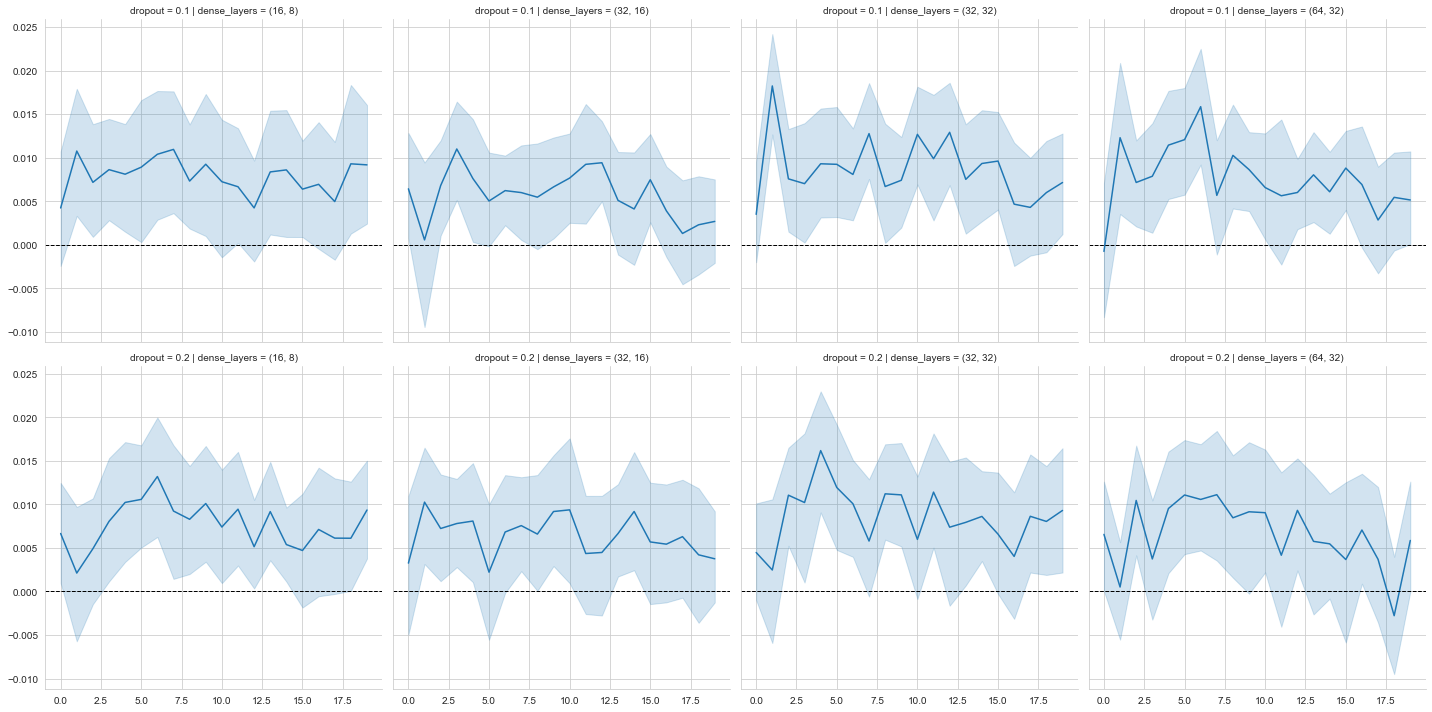

In [29]:
g = sns.relplot(x='epoch', y='ic', col='dense_layers', row='dropout', 
                data=ic_long[ic_long.dropout>0], kind='line')
g.map(plt.axhline, y=0, ls='--', c='k', lw=1)
g.savefig(results_path / 'ic_lineplot', dpi=300);

In [30]:
def run_ols(ic):
    ic.dense_layers = ic.dense_layers.str.replace(', ', '-').str.replace('(', '').str.replace(')', '')
    data = pd.melt(ic, id_vars=params, var_name='epoch', value_name='ic')
    data.epoch = data.epoch.astype(int).astype(str).apply(lambda x: f'{int(x):02.0f}')
    model_data = pd.get_dummies(data.sort_values(params + ['epoch']), columns=['epoch'] + params, drop_first=True).sort_index(1)
    model_data.columns = [s.split('_')[-1] for s in model_data.columns]
    model = sm.OLS(endog=model_data.ic, exog=sm.add_constant(model_data.drop('ic', axis=1)))
    return model.fit()

In [31]:
model = run_ols(ic.drop('fold', axis=1))

In [32]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     ic   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     3.108
Date:                Mon, 22 Jun 2020   Prob (F-statistic):           2.60e-07
Time:                        06:52:08   Log-Likelihood:             2.3148e+05
No. Observations:              362880   AIC:                        -4.629e+05
Df Residuals:                  362854   BIC:                        -4.626e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      1.960      0.0

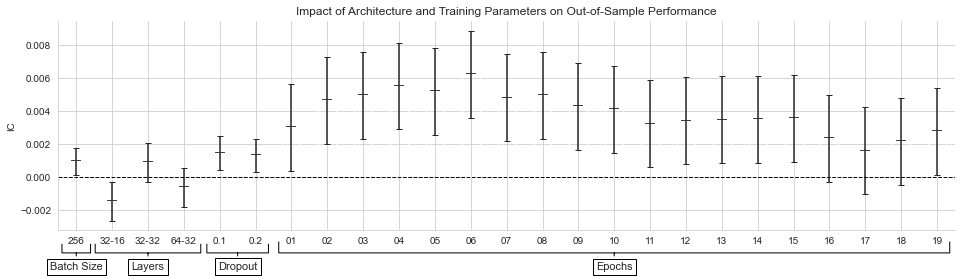

In [33]:
fig, ax = plt.subplots(figsize=(14, 4))

ci = model.conf_int()
errors = ci[1].sub(ci[0]).div(2)

coefs = (model.params.to_frame('coef').assign(error=errors)
         .reset_index().rename(columns={'index': 'variable'}))
coefs = coefs[~coefs['variable'].str.startswith('date') & (coefs.variable != 'const')]

coefs.plot(x='variable', y='coef', kind='bar',
           ax=ax, color='none', capsize=3,
           yerr='error', legend=False, rot=0, title='Impact of Architecture and Training Parameters on Out-of-Sample Performance')
ax.set_ylabel('IC')
ax.set_xlabel('')
ax.scatter(x=pd.np.arange(len(coefs)), marker='_', s=120, y=coefs['coef'], color='black')
ax.axhline(y=0, linestyle='--', color='black', linewidth=1)
ax.xaxis.set_ticks_position('none')

ax.annotate('Batch Size', xy=(.02, -0.1), xytext=(.02, -0.2),
            xycoords='axes fraction',
            textcoords='axes fraction',
            fontsize=11, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white', ec='black'),
            arrowprops=dict(arrowstyle='-[, widthB=1.3, lengthB=0.8', lw=1.0, color='black'))

ax.annotate('Layers', xy=(.1, -0.1), xytext=(.1, -0.2),
            xycoords='axes fraction',
            textcoords='axes fraction',
            fontsize=11, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white', ec='black'),
            arrowprops=dict(arrowstyle='-[, widthB=4.8, lengthB=0.8', lw=1.0, color='black'))

ax.annotate('Dropout', xy=(.2, -0.1), xytext=(.2, -0.2),
            xycoords='axes fraction',
            textcoords='axes fraction',
            fontsize=11, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white', ec='black'),
            arrowprops=dict(arrowstyle='-[, widthB=2.8, lengthB=0.8', lw=1.0, color='black'))

ax.annotate('Epochs', xy=(.62, -0.1), xytext=(.62, -0.2),
            xycoords='axes fraction',
            textcoords='axes fraction',
            fontsize=11, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white', ec='black'),
            arrowprops=dict(arrowstyle='-[, widthB=30.5, lengthB=1.0', lw=1.0, color='black'))

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'ols_coef', dpi=300)

## Make Predictions

In [83]:
def get_best_params(n=5):
    """Get the best parameters across all folds by daily median IC"""
    params = ['dense_layers', 'activation', 'dropout', 'batch_size']
    ic = pd.read_hdf(results_path / 'scores.h5', 'ic_by_day').drop('fold', axis=1)
    dates = sorted(ic.index.unique())
    train_period = 24 * 21
    train_dates = dates[:train_period]
    ic = ic.loc[train_dates]
    return (ic.groupby(params)
            .median()
            .stack()
            .to_frame('ic')
            .reset_index()
            .rename(columns={'level_4': 'epoch'})
            .nlargest(n=n, columns='ic')
            .drop('ic', axis=1)
            .to_dict('records'))

In [84]:
def generate_predictions(dense_layers, activation, dropout, batch_size, epoch):
    data = pd.read_hdf('../12_gradient_boosting_machines/data.h5', 'model_data').dropna()
    outcomes = data.filter(like='fwd').columns.tolist()
    X_cv = data.loc[idx[:, :'2017'], :].drop(outcomes, axis=1)
    input_dim = X_cv.shape[1]
    y_cv = data.loc[idx[:, :'2017'], 'r01_fwd']

    scaler = StandardScaler()
    predictions = []
    
    do = '0' if str(dropout) == '0.0' else str(dropout)
    checkpoint_dir = checkpoint_path / dense_layers / activation / do / str(batch_size)
        
    for fold, (train_idx, test_idx) in enumerate(cv.split(X_cv)):
        x_train, y_train, x_val, y_val = get_train_valid_data(X_cv, y_cv, train_idx, test_idx)
        x_val = scaler.fit(x_train).transform(x_val)
        model = make_model(make_tuple(dense_layers), activation, dropout)
        status = model.load_weights((checkpoint_dir / f'ckpt_{fold}_{epoch}').as_posix())
        status.expect_partial()
        predictions.append(pd.Series(model.predict(x_val).squeeze(), index=y_val.index))
    return pd.concat(predictions)        

In [85]:
best_params = get_best_params()
predictions = []
for i, params in enumerate(best_params):
    predictions.append(generate_predictions(**params).to_frame(i))

predictions = pd.concat(predictions, axis=1)
print(predictions.info())
predictions.to_hdf(results_path / 'test_preds.h5', 'predictions')

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 748960 entries, ('A', Timestamp('2017-08-30 00:00:00')) to ('ZION', Timestamp('2015-03-02 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       748960 non-null  float32
 1   1       748960 non-null  float32
 2   2       748960 non-null  float32
 3   3       748960 non-null  float32
 4   4       748960 non-null  float32
dtypes: float32(5)
memory usage: 17.2+ MB
None


### How to further improve the results

The relatively simple architecture yields some promising results. To further improve performance, you can
- First and foremost, add new features and more data to the model
- Expand the set of architectures to explore, including more or wider layers
- Inspect the training progress and train for more epochs if the validation error continued to improve at 50 epochs

Finally, you can use more sophisticated architectures, including Recurrent Neural Networks (RNN) and Convolutional Neural Networks that are well suited to sequential data, whereas vanilla feedforward NNs are not designed to capture the ordered nature of the features.
